In [251]:
import numpy
import math
from matplotlib import pyplot
# embed the figures into the notebook
%matplotlib inline
%run ./definitions.ipynb

import os
import numpy
import scipy
from scipy import integrate, linalg, optimize

## Part 2: Wenzinger's test case

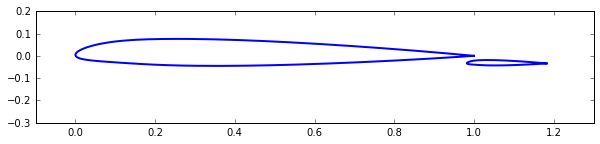

In [286]:
# some knowns
N = 150               # each
Nx, Ny = 100, 100     # just for consistency
steps = 1

# some initializing
panels = numpy.empty((steps,2*N), dtype=object)
mainpanels = numpy.empty((steps,N), dtype=object)
flappanels = numpy.empty((steps,N), dtype=object)
xf = numpy.empty((steps,2*N), dtype=object)
yf = numpy.empty((steps,2*N), dtype=object)
u, v = numpy.empty((steps, Nx, Ny), dtype=float), \
        numpy.empty((steps, Nx, Ny), dtype=float)
cp = numpy.empty((steps, Nx, Ny), dtype=float)
# accuracy = numpy.empty(steps, dtype=float)
lift, drag = numpy.empty(steps, dtype=float),numpy.empty(steps, dtype=float)
cl = numpy.empty(steps, dtype=float)
u_inf = 1.0
alpha = 0.0
freestream = Freestream(u_inf, alpha)

# picking up some x and y values
mainfoilpath = os.path.join('resources','NACA23012_MainFoil.csv')
with open (mainfoilpath, 'r') as file_name:
    xmain, ymain = numpy.loadtxt(file_name, dtype=float, delimiter=',', unpack=True)

flapfoilpath = os.path.join('resources','NACA23012_FlapFoil.csv')
with open (flapfoilpath, 'r') as file_name:
    xflap, yflap = numpy.loadtxt(file_name, dtype=float, delimiter=',', unpack=True)
    
# picking my friends 
xa, xz, ya, yz = -0.1, 1.3, -0.3, 0.2
l_main = numpy.max(xmain)-numpy.min(xmain)
l_flap = numpy.max(xflap)-numpy.min(xflap)
l_total = l_main + l_flap
xc, yc = 1.03, -0.054

# plot em
pyplot.figure(figsize=(10,2))
pyplot.plot(xmain, ymain, xflap, yflap,  color='b', linestyle='-', linewidth=2)
pyplot.xlim(xa, xz)
pyplot.ylim(ya, yz);

In [287]:
def theta_transform(x, y, xc, yc, theta):
    """
    
    for rotating foil around a point
    
    Arguments
    ---------
    x, y: arrays of panel endpoinst
    xc, yc: location of center of rotation
    theta: angle of rotation, in degrees
    
    Returns
    -------
    xr, yr: rotated points
    
    """ 
    
    theta = theta * math.pi / 180
    
    x = x - xc
    y = y - yc

    xnew = x * math.cos(theta) + y * math.sin(theta)
    ynew = -x * math.sin(theta) + y * math.cos(theta)

    xr = xnew + xc 
    yr = ynew + yc
    
    return xr, yr

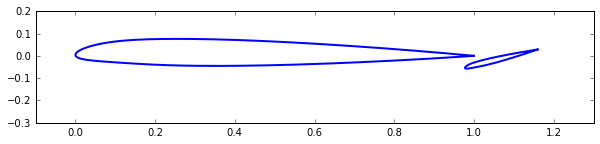

In [295]:
theta = -25

xflap, yflap = theta_transform(xflap, yflap, xc, yc, theta)

pyplot.figure(figsize=(10,2))
pyplot.plot(xmain, ymain, xflap, yflap,  color='b', linestyle='-', linewidth=2)
pyplot.xlim(xa, xz)
pyplot.ylim(ya, yz);

In [296]:
u_inf = 1.0
alpha = 0
freestream = Freestream(u_inf, alpha)

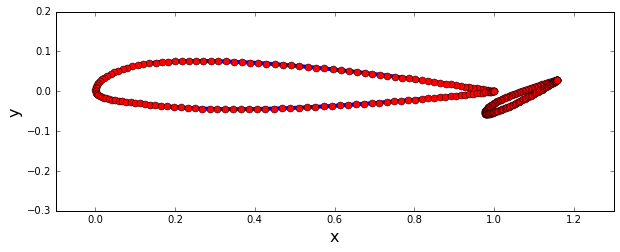

In [297]:
mainpanels = cam_define_panels(xmain,ymain,len(xmain)-1)
flappanels = cam_define_panels(xflap,yflap,len(xflap)-1)
panels = numpy.concatenate((mainpanels, flappanels), axis=0)

# and plot this
width = 10
pyplot.figure(figsize=(width, width))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(xmain, ymain, xflap, yflap, color='b', linestyle='-', linewidth=4)
pyplot.plot(numpy.append([panel.xa for panel in panels], panels[0].xa),
            numpy.append([panel.ya for panel in panels], panels[0].ya),
            linestyle='-', linewidth=0, marker='o', markersize=7, color='r')
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(xa, xz)
pyplot.ylim(ya, yz);

# Get our scaling right for the plots
val_x, val_y = 2.0, 4.0
x_min, x_max = numpy.min( [panel.xa for panel in mainpanels] ), numpy.max( [panel.xa for panel in flappanels] )
y_min, y_max = numpy.min( [panel.ya for panel in flappanels] ), numpy.max( [panel.ya for panel in mainpanels] )
x_start, x_end = x_min-val_x*(x_max-x_min), x_max+val_x*(x_max-x_min)
y_start, y_end = y_min-val_y*(y_max-y_min), y_max+val_y*(y_max-y_min)

# Create our meshgrid for the plots
x, y, X, Y = makemesh(N, x_start, x_end, y_start, y_end)

In [298]:
A, At = build_matrix(panels)
b = build_rhs(panels, freestream)
variables = numpy.linalg.solve(A,b)

/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:56: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:57: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:61: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:62: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:73: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__

In [299]:
for j, panel in enumerate(panels):
    panel.sigma = variables[j]
        
gamma = variables[-2:]
get_tangential_velocity(panels, freestream, gamma, At)
get_pressure_coefficient(panels, freestream)
panel_main, panel_flap = panels[0:N], panels[N:]

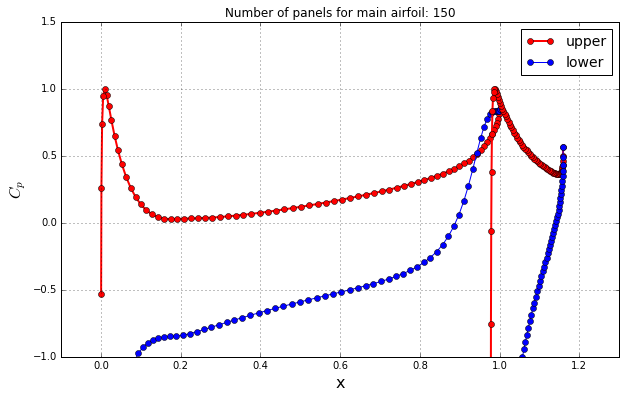

In [300]:
pyplot.figure(figsize=(10, 6))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot([panel.xc for panel in panel_main if panel.loc == 'upper'], 
         [panel.cp for panel in panel_main if panel.loc == 'upper'], 
         color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in panel_main if panel.loc == 'lower'], 
         [panel.cp for panel in panel_main if panel.loc == 'lower'], 
         color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in flappanels if panel.loc == 'upper'],
            [panel.cp for panel in flappanels if panel.loc == 'upper'],
            label='upper surface',
            color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in flappanels if panel.loc == 'lower'],
            [panel.cp for panel in flappanels if panel.loc == 'lower'],
            label= 'lower surface',
            color='b', linestyle='-', linewidth=1, marker='o', markersize=6)

pyplot.legend(['upper', 'lower'], loc='best', prop={'size':14})
pyplot.xlim(-0.1, 1.3)
pyplot.ylim(-1,1.5)
pyplot.title('Number of panels for main airfoil: %d' % N);

In [301]:
panels = numpy.concatenate((panel_main, panel_flap), axis=0)

lift = 0
drag = 0

#accuracy = sum([panel.sigma*panel.length for panel in panel_main])
#accuracy += sum([panel.sigma*panel.length for panel in panel_flap])
    
for panel in panels:
    lift -= panel.cp * panel.length * math.sin(panel.beta)
    drag += panel.cp * panel.length * math.cos(panel.beta) 
    
# Question 5  
print('Q5')  
print('\nLift value:', str(lift))
#print('Accuracy:', str(accuracy))
print('Alpha: ', str(alpha))

Q5

Lift value: -1.18403000116
Alpha:  0


## Question 1

In [266]:
# picking up some x and y values
mainfoilpath = os.path.join('resources','NACA23012_MainFoil.csv')
with open (mainfoilpath, 'r') as file_name:
    xmain, ymain = numpy.loadtxt(file_name, dtype=float, delimiter=',', unpack=True)

flapfoilpath = os.path.join('resources','NACA23012_FlapFoil.csv')
with open (flapfoilpath, 'r') as file_name:
    xflap, yflap = numpy.loadtxt(file_name, dtype=float, delimiter=',', unpack=True)

# rotating the flap
theta = 20
xc, yc = 1.03, -0.054
xflap, yflap = theta_transform(xflap, yflap, xc, yc, theta)

mainpanels = cam_define_panels(xmain,ymain,len(xmain)-1)
flappanels = cam_define_panels(xflap,yflap,len(xflap)-1)
panels = numpy.concatenate((mainpanels, flappanels), axis=0)

A, At = build_matrix(panels)

value1 = 14.0
value2 = -14.0
c = abs(value1-value2)
run = 0
midpoint = (value1+value2)/2

lift = 100

print('run \t\tvalue1 \t\tvalue2 \t\ttestpoint \ttest-lift')

while c > 0.0001:
    run += 1
    u_inf = 1.0
    alpha = midpoint
    freestream = Freestream(u_inf, alpha)
    b = build_rhs(panels, freestream)
    variables = numpy.linalg.solve(A,b)

    for j, panel in enumerate(panels):
        panel.sigma = variables[j]
        
    gamma = variables[-2:]
    get_tangential_velocity(panels, freestream, gamma, At)
    get_pressure_coefficient(panels, freestream)
    panel_main, panel_flap = panels[0:N], panels[N:]

    lift = 0.0
    drag = 0.0

    for panel in panels:
        lift -= panel.cp * panel.length * math.sin(panel.beta)
        drag += panel.cp * panel.length * math.cos(panel.beta)
        
    print(str(run) + '\t\t%.3f\t\t%.3f\t\t%.3f\t\t%.6f' % (value1, value2, midpoint, lift))
    
    if lift > 0.0:
        value1 = float(midpoint)
    
    if lift < 0.0:
        value2 = float(midpoint)
        
    c = abs(value1 - value2)
        
    midpoint = (value1+value2)/2
    
print('\n\nalpha:',str(value1))

run 		value1 		value2 		testpoint 	test-lift
1		14.000		-14.000		0.000		1.520186
2		0.000		-14.000		-7.000		0.548338
3		-7.000		-14.000		-10.500		0.063499
4		-10.500		-14.000		-12.250		-0.175477
5		-10.500		-12.250		-11.375		-0.056370
6		-10.500		-11.375		-10.938		0.003477
7		-10.938		-11.375		-11.156		-0.026469
8		-10.938		-11.156		-11.047		-0.011502
9		-10.938		-11.047		-10.992		-0.004014
10		-10.938		-10.992		-10.965		-0.000269
11		-10.938		-10.965		-10.951		0.001604
12		-10.951		-10.965		-10.958		0.000667
13		-10.958		-10.965		-10.961		0.000199
14		-10.961		-10.965		-10.963		-0.000035
15		-10.961		-10.963		-10.962		0.000082
16		-10.962		-10.963		-10.963		0.000023
17		-10.963		-10.963		-10.963		-0.000006
18		-10.963		-10.963		-10.963		0.000009
19		-10.963		-10.963		-10.963		0.000001


alpha: -10.962867736816406


/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:56: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:57: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:61: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:62: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:73: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__

## Question 2

In [302]:
# picking up some x and y values
mainfoilpath = os.path.join('resources','NACA23012_MainFoil.csv')
with open (mainfoilpath, 'r') as file_name:
    xmain, ymain = numpy.loadtxt(file_name, dtype=float, delimiter=',', unpack=True)

flapfoilpath = os.path.join('resources','NACA23012_FlapFoil.csv')
with open (flapfoilpath, 'r') as file_name:
    xflap, yflap = numpy.loadtxt(file_name, dtype=float, delimiter=',', unpack=True)

# rotating the angle of attack
xc, yc = 1.03, -0.054
origxflap, origyflap = xflap, yflap

u_inf = 1.0
alpha = 0
freestream = Freestream(u_inf, alpha)

A, At = build_matrix(panels)

value1 = 0
value2 = -25
c = abs(value1-value2)
run = 0
midpoint = (value1+value2)/2
xc, yc = 1.03, -0.054

print('run \t\tvalue1 \t\tvalue2 \t\ttestpoint \ttest-lift')

while c > 0.001:
    xflap, yflap = origxflap, origyflap
    run += 1
    
    theta = midpoint
    xflap, yflap = theta_transform(xflap, yflap, xc, yc, theta)

    mainpanels = cam_define_panels(xmain,ymain,len(xmain)-1)
    flappanels = cam_define_panels(xflap,yflap,len(xflap)-1)
    panels = numpy.concatenate((mainpanels, flappanels), axis=0)

    A, At = build_matrix(panels)
    b = build_rhs(panels, freestream)
    variables = numpy.linalg.solve(A,b)

    for j, panel in enumerate(panels):
        panel.sigma = variables[j]
        
    gamma = variables[-2:]
    get_tangential_velocity(panels, freestream, gamma, At)
    get_pressure_coefficient(panels, freestream)
    panel_main, panel_flap = panels[0:N], panels[N:]

    lift = 0.0
    drag = 0.0

    for panel in panels:
        lift -= panel.cp * panel.length * math.sin(panel.beta)
        drag += panel.cp * panel.length * math.cos(panel.beta)
        
    print(str(run) + '\t\t%.3f\t\t%.3f\t\t%.3f\t\t%.6f' % (value1, value2, midpoint, lift))
    
    if lift > 0.0:
        value1 = float(midpoint)
    
    if lift < 0.0:
        value2 = float(midpoint)
        
    c = abs(value1 - value2)
        
    midpoint = (value1+value2)/2
    
print('\n\nalpha:',str(value1))

/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:56: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:57: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:61: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:62: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:73: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


run 		value1 		value2 		testpoint 	test-lift


/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:23: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


1		0.000		-25.000		-12.500		-0.472137
2		0.000		-12.500		-6.250		-0.103853
3		0.000		-6.250		-3.125		0.083120
4		-3.125		-6.250		-4.688		-0.010597
5		-3.125		-4.688		-3.906		0.036204
6		-3.906		-4.688		-4.297		0.012790
7		-4.297		-4.688		-4.492		0.001093
8		-4.492		-4.688		-4.590		-0.004753
9		-4.492		-4.590		-4.541		-0.001830
10		-4.492		-4.541		-4.517		-0.000369
11		-4.492		-4.517		-4.504		0.000362
12		-4.504		-4.517		-4.510		-0.000003
13		-4.504		-4.510		-4.507		0.000179


KeyboardInterrupt: 